In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [3]:
from collections import Counter, defaultdict, OrderedDict, namedtuple
import copy

In [4]:
en_stopwords = set(stopwords.words('english'))

In [5]:
def not_stopword(word):
    return word.lower() not in en_stopwords

In [6]:
def not_all_punct(word):
    return not all([not c.isalnum() for c in word])

In [7]:
def to_lower(word):
    return word.lower()

In [8]:
snowball = SnowballStemmer('english')
def stemmer(word):
    return snowball.stem(word)

In [9]:
#parser_type = 'xml'
#parser_type = 'html.parser'
#parser_type = 'lxml'
parser_type = 'lxml-xml'
#parser_type = 'html5lib'

In [10]:
%%time
with open("data/allRecsWithAbstractsEscaped.xml") as f:
    full_data = BeautifulSoup(f, features=parser_type)

CPU times: user 4min 10s, sys: 20.2 s, total: 4min 30s
Wall time: 4min 33s


In [11]:
def explore(tag, by_level=None, indent=0):
    if by_level is None:
        by_level = []
    if len(by_level) <= indent:
        by_level.append(set())
    by_level[indent].add(tag.name)
    for c in tag.find_all(text=False, recursive=False):
        by_level = explore(c, by_level, indent=indent+1)
    return by_level

In [12]:
%%time
by_level = explore(full_data.records)

for level_index, tags in enumerate(by_level):
    print('  '*level_index + u', '.join(sorted(list(tags))))

records
  record
    abstract, identifier, subject, title
CPU times: user 2min 47s, sys: 3.79 s, total: 2min 51s
Wall time: 2min 51s


In [13]:
class Record(namedtuple("Record", ["title", "identifier", "abstract", "subjects"])):
    pass

In [14]:
len(full_data.records.find_all(text=False, recursive=False))

483052

In [15]:
def process_records(data, limit=None):
    result = []

    for r in data.records.find_all(text=False, recursive=False, limit=limit):
        if r.name != "record":
            raise Exception(u"Unexpected child node of records: {} != record".format(r.name))

        title = r.title.string
        abstract = r.abstract.string
        subjects = [x.string for x in r.find_all("subject", recursive=False)]
        identifier = r.identifier.string

        r_obj = Record(title=title, identifier=identifier, abstract=abstract, subjects=subjects)
        result.append(r_obj)

    return result

In [16]:
%%time
record_objects = process_records(data = full_data, limit = None)
print(len(record_objects))

483052
CPU times: user 1min 42s, sys: 238 ms, total: 1min 42s
Wall time: 1min 42s


In [17]:
auto_cleanup = True

In [18]:
if auto_cleanup:
    print("Cleaning up bs4 objects")
    full_data.decompose()
    del full_data
else:
    print("NOT cleaning up")

Cleaning up bs4 objects


In [19]:
class MyTokenizer(object):
    def __init__(self,
            transforms=None,
            filters=None,
            word_tokenizer=None,
            sent_tokenizer=None):

        if transforms is None:
            transforms = []
        if word_tokenizer is None:
            word_tokenizer = word_tokenize
        if filters is None:
            filters = []
        self.word_tokenizer = word_tokenizer
        self.sent_tokenizer = sent_tokenizer
        self.filters = filters
        self.transforms = transforms

    def tokenize(self, str_to_tokenize):
        if self.sent_tokenizer is None:
            sentences = [str_to_tokenize]
        else:
            sentences = self.sent_tokenizer(str_to_tokenize)

        tokens_by_sentence = []
        for sent in sentences:
            tokens = []
            for t in self.word_tokenizer(sent):
                include_token = all(f(t) for f in self.filters)
                if include_token:
                    transformed = t
                    for tr in self.transforms:
                        transformed = tr(t)
                    tokens.append(transformed)
                    
            tokens_by_sentence.append(tokens)

        if self.sent_tokenizer is None:
            return tokens_by_sentence[0]
        else:
            return tokens_by_sentence

In [20]:
tokenizer = MyTokenizer(
    filters = [not_all_punct, not_stopword],
    transforms = [to_lower, stemmer],
    word_tokenizer = word_tokenize,
    sent_tokenizer = None)

In [21]:
import tqdm

In [22]:
%%time

all_subjects = set()
all_token_indices = dict()
all_tokens_sorted = []
stats_by_document = []
token_indices_by_document = []

documents_with_nonempty_abstracts = []

do_tokens = True

rec_count = 0
for doc_index, r in enumerate(tqdm.tqdm(record_objects)):
    stats_by_document.append(OrderedDict([
        ('abstract_length_chars', len(r.abstract) if r.abstract is not None else 0),
        ('num_subjects', len(r.subjects)),
    ]))

    all_subjects |= set(r.subjects)

    if do_tokens and r.abstract is not None:
        tokens = tokenizer.tokenize(r.abstract)
    else:
        tokens = []

    current_token_indices = []
    for t in tokens:
        if t not in all_token_indices:
            all_token_indices[t] = len(all_token_indices)
            all_tokens_sorted.append(t)
        current_token_indices.append(all_token_indices[t])
    token_indices_by_document.append(current_token_indices)

    if len(current_token_indices) > 0:
        documents_with_nonempty_abstracts.append(doc_index)
    
#     if rec_count < 5:
#         print(u"=============")
#         print(u"Title: {}".format(r.title))
#         print(u"Abstract: {}".format(r.abstract))
#         print(u"Subjects ({}): {}".format(len(r.subjects), u"; ".join(r.subjects)))
#         print(u"Tokens: {}".format(tokens))

    rec_count += 1

all_subjects = sorted(list(all_subjects))
stats_by_document = pd.DataFrame.from_records(stats_by_document)

100%|██████████| 483052/483052 [25:28<00:00, 315.96it/s]


CPU times: user 24min 43s, sys: 22.8 s, total: 25min 6s
Wall time: 25min 30s


In [23]:
print(u"Total number of records: {}".format(rec_count))
print(u"Total number of nonempty abstracts: {}".format(len(documents_with_nonempty_abstracts)))
print(u"Total number of subjects: {}".format(len(all_subjects)))
print(u"Total number of tokens: {}".format(len(all_token_indices)))

Total number of records: 483052
Total number of nonempty abstracts: 480887
Total number of subjects: 26862
Total number of tokens: 511462


In [24]:
from scipy.sparse import dok_matrix

In [25]:
%%time
# Construct sparse term-document matrix
vocab_size = len(all_token_indices)
num_nonempty_docs = len(documents_with_nonempty_abstracts)
term_doc_matrix = dok_matrix((vocab_size, num_nonempty_docs), dtype='int')
for indirect_index, doc_index in enumerate(tqdm.tqdm(documents_with_nonempty_abstracts)):
    for term_index in token_indices_by_document[doc_index]:
        term_doc_matrix[term_index, indirect_index] += 1
term_doc_matrix = term_doc_matrix.tocsc()
print("Constructed sparse matrix with shape {} and {} nonzero entries"
    .format(term_doc_matrix.shape, term_doc_matrix.nnz))

100%|██████████| 480887/480887 [12:48<00:00, 625.74it/s]


Constructed sparse matrix with shape (511462, 480887) and 25441094 nonzero entries
CPU times: user 13min 8s, sys: 15.7 s, total: 13min 23s
Wall time: 13min 29s


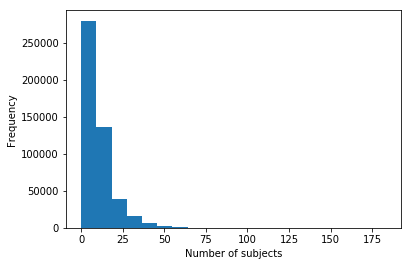

In [26]:
fig, ax = plt.subplots()
ax.hist(stats_by_document["num_subjects"], bins=20)
ax.set_xlabel('Number of subjects')
ax.set_ylabel('Frequency')
None

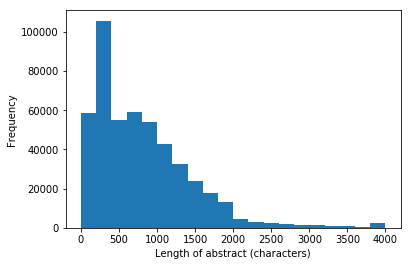

In [27]:
fig, ax = plt.subplots()
ax.hist(stats_by_document["abstract_length_chars"], bins=20)
ax.set_xlabel('Length of abstract (characters)')
ax.set_ylabel('Frequency')
None

In [28]:
u_subjects = np.sort(np.unique(all_subjects))

In [29]:
len(u_subjects)

26862

In [30]:
len(record_objects)

483052

In [31]:
%%time
from scipy.io import savemat
savemat("data/abstracts.mat", {'M' : term_doc_matrix}, oned_as='column')

CPU times: user 900 ms, sys: 283 ms, total: 1.18 s
Wall time: 1.29 s


In [32]:
%%time
with open("data/abstracts_vocab.txt", 'w') as f:
    for t in tqdm.tqdm(all_tokens_sorted):
        print(t, file=f)

100%|██████████| 511462/511462 [00:00<00:00, 596317.49it/s]

CPU times: user 815 ms, sys: 41.3 ms, total: 856 ms
Wall time: 865 ms


In [33]:
%%time
with open("data/abstracts_nonempty_doc_indices.txt", 'w') as f:
    for i in tqdm.tqdm(documents_with_nonempty_abstracts):
        print(i, file=f)

100%|██████████| 480887/480887 [00:00<00:00, 590528.72it/s]

CPU times: user 797 ms, sys: 19 ms, total: 816 ms
Wall time: 819 ms


In [34]:
# TODO: 